# Проект для крупного производителя одежды

## Цель: персонализация частоты рассылок

## Описание проекта

**Ожидаемый бизнес-результат:** клиенты с превышением лимита по отправкам будут изыматься и таргета.
Со временем в него возвращаться. При этом они не будут терять интерес к рассылкам , меньше будут
отписываться, будут дольше оставаться в программе.

### Задачи

1. Определить оптимальную частоту рассылок на уровне клиента для минимизации рисков по оттоку, в
т.ч. пассивному оттоку, без снижения моментального траффика/продаж. Второе в приоритете.

2. Проверить гипотезы
 - Гипотеза о “пассивной отписке”: когда человеку показалось, что ему пишут слишком много, и он просто перестает открывать рассылки, хоть и не готов отписываться
 - Клиент совершает покупку и какое-то время теряет интерес к новостным рассылкам, во всяком случае рассылки на пользователя не генерят продажи

### Декомпозиция проекта.

### Шаг 1. Загрузка данных и предобработка данных

- проверим в данных пропуски, типы, аномалии, дубликаты, наименования колонок

### Шаг 2. Исследовательский анализ данных (EDA)

 - Посмотрим на датасет: есть ли в нем отсутствующие признаки, изучим средние значения и стандартные отклонения и прочее;
 - Выясним нужно ли бороться с выбросами;

### Шаг 3. Формулировка и проверка статистических гипотез. Ответы на вопросы заказчика

- Определение оптимальной частоты рассылок на уровне клиента для минимизации рисков по оттоку, в т.ч. пассивному оттоку, без снижения моментального траффика/продаж. 
- Гипотеза о “пассивной отписке”: когда человеку показалось, что ему пишут слишком много, и он просто перестает открывать рассылки, хоть и не готов отписываться
- Гипотеза - Клиент совершает покупку и какое-то время теряет интерес к новостным рассылкам, во всяком случае рассылки на пользователя не генерят продажи
- Кластеризация клиентов

### Шаг. 4. Презентация и оформление проекта

- общие выводы;
- вкладка readme : как читать таблицу;
- вкладка с таблицей: идентификатор клиента – рекомендуемое количество кампаний в месяц. Отметить, если количество кампаний выше среднего.

*Презентация:*

- Ответы на вопросы заказчика
- Подробное описание методологии расчёта количества рассылок
- Ссылка на таблицу в Google Sheets
- Выводы и рекомендации


### Шаг 1. Загрузка данных и предоработка данных

In [1]:
import pandas as pd
import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import warnings

# задействуем фичи, от ошибок при повторном использовании одного и того же df
# и для отображения трёх символов после запятой для всех значений с плавающей запятой
# малые финансовые переменные любят 2-3 значения после запятой 
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
# загрузим датасеты 
path = 'C:/Users/PC/проекты Яндекс/Датасеты/'
campaings = pd.read_excel(path + 'CAMPAIGNS JUL19.xlsx')
engagement = pd.read_excel(path + 'ENGAGEMENTS_JUL19.xlsx')
transactions = pd.read_excel(path + 'TRANSACTIONS JUL19.xlsx')
members = pd.read_excel(path + 'MEMBS JUL19.xlsx')

In [3]:
campaings.head()

,Campaign Delivery ID,Sent Date Hour ID,Sent
0,643100000215092,2019-07-21 09:00:00,274
1,643100000248888,2019-08-06 09:00:00,2473
2,643100000248888,2019-08-09 09:00:00,6
3,643100000248888,2019-08-21 15:00:00,13
4,643100000248888,2019-08-30 14:00:00,23


In [4]:
campaings['Sent'].sum()

919493

**Таблица кампаний**

`Campaign Delivery ID` - id кампаний

`Sent Date Hour ID` - дата и время отправки

`Sent` - !техническая колонка (можно игнорировать)

In [5]:
engagement.head()

,Consumer SEUCI ID,Campaign Delivery ID,Opened Date Hour ID,Sent,Delivered,Opened,Clicked,Unsubscribed
0,003GH1K9GPLAB0WG,643100000258617,NaT,1,1,nan,nan,nan
1,003GH1K9GPLAB0WG,643100000266591,NaT,1,1,nan,nan,nan
2,003GH1K9GPLAB0WG,643100000268184,NaT,1,1,nan,nan,nan
3,003GH1K9GPLAB0WG,643100000280834,NaT,1,1,nan,nan,nan
4,003GH1K9GPLAB0WG,643100000299637,NaT,1,1,nan,nan,nan


In [6]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 919961 entries, 0 to 919960
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Consumer SEUCI ID     919961 non-null  object        
 1   Campaign Delivery ID  919961 non-null  int64         
 2   Opened Date Hour ID   86453 non-null   datetime64[ns]
 3   Sent                  919961 non-null  int64         
 4   Delivered             919961 non-null  int64         
 5   Opened                86453 non-null   float64       
 6   Clicked               13832 non-null   float64       
 7   Unsubscribed          658 non-null     float64       
dtypes: datetime64[ns](1), float64(3), int64(3), object(1)
memory usage: 56.2+ MB


**Таблица взаимодействий**

`Consumer SEUCI ID` - id кампаний

`Campaign Delivery ID` - Id кампании (если клиент попал в таргет)

`Opened Date Hour ID` - Дата и время открытия письма

`Sent` - это попытка отправки 

`Delivered` - факт доставки сообщения

`Opened` - Клиент открыл письмо (0/1)

`Clicked` - Клиент кликнул по контенту письма = перешел на сайт/app (0/1)

`Unsubscribed` - Клиент отписался от рассылки с этого письма (0/1)

In [7]:
transactions.head()

,Consumer SEUCI ID,Order Date ID,Nr of Transactions
0,0049U5ZF5M0KFYTZ,2019-07-02,1
1,006ZYWZO9M7FS9BT,2019-07-01,1
2,006ZYWZO9M7FS9BT,2020-01-29,1
3,00SC6AIM4AZ0RL4N,2019-07-24,1
4,00UFVL6NWLOKB7S5,2019-09-19,1


In [8]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13997 entries, 0 to 13996
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Consumer SEUCI ID   13997 non-null  object        
 1   Order Date ID       13997 non-null  datetime64[ns]
 2   Nr of Transactions  13997 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 328.2+ KB


**Таблица заказов**

`сonsumer_id` - Id клиента

`order_date_id` - Дата транзакции

`nr_of_transactions` - Кол-во транзакций

In [9]:
members.head()

,Consumer SEUCI ID,Age ID,Gender DESC,First Signup Date ID,Sent
0,003GH1K9GPLAB0WG,nan,Not Set,2019-07-01,51
1,0049U5ZF5M0KFYTZ,39.000,Male,2019-07-02,104
2,006ZYWZO9M7FS9BT,33.000,Male,2019-07-01,149
3,00720YKABZ6J9ZJ1,nan,Female,2019-07-01,47
4,009LQ66BFK5BIS1S,26.000,Male,2019-07-01,2


In [10]:
members.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14065 entries, 0 to 14064
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Consumer SEUCI ID     14065 non-null  object        
 1   Age ID                10981 non-null  float64       
 2   Gender DESC           14065 non-null  object        
 3   First Signup Date ID  14065 non-null  datetime64[ns]
 4   Sent                  14065 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 549.5+ KB


**Таблица клиентов**

`сonsumer_id` - Id клента

`age_id` - Возраст

`gender` - Пол

`first_signup_date_id` - Дата регистрациии 

`sent` - !техническая колонка (можно игнорировать)

### Изменим наименования столбоцов для удобвства

In [11]:
campaings.columns

Index(['Campaign Delivery ID', 'Sent Date Hour ID', 'Sent'], dtype='object')

In [12]:
campaings = campaings.drop(columns = ['Sent']).rename(columns={'Campaign Delivery ID':'campaign_delivery_id', 
                                      'Sent Date Hour ID':'sent_date_hour'})

In [13]:
engagement.columns

Index(['Consumer SEUCI ID', 'Campaign Delivery ID', 'Opened Date Hour ID',
       'Sent', 'Delivered', 'Opened', 'Clicked', 'Unsubscribed'],
      dtype='object')

In [14]:
engagement = engagement.rename(columns={'Consumer SEUCI ID':'сonsumer_id', 'Campaign Delivery ID':'campaign_delivery_id',
                                        'Opened Date Hour ID':'opened_date_hour', 'Sent Date Hour ID':'sent_date_hour', 
                                        'Delivered':'delivered', 'Clicked':'clicked', 'Unsubscribed':'unsubscribed', 'Opened':'opened', 'Sent':'sent'})

In [15]:
transactions.columns

Index(['Consumer SEUCI ID', 'Order Date ID', 'Nr of Transactions'], dtype='object')

In [16]:
transactions = transactions.rename(columns={'Consumer SEUCI ID':'сonsumer_id', 
                                    'Order Date ID':'order_date', 
                                    'Nr of Transactions':'nr_of_transactions'})

In [17]:
members.columns

Index(['Consumer SEUCI ID', 'Age ID', 'Gender DESC', 'First Signup Date ID',
       'Sent'],
      dtype='object')

In [18]:
members = members.drop(columns = ['Sent']).rename(columns={'Consumer SEUCI ID':'сonsumer_id', 
                                  'Age ID':'age', 'Gender DESC':'gender',
                                  'First Signup Date ID':'first_signup_date'})

## Шаг 2. Исследовательский анализ данных (EDA)

### Рассмотрим первичные значения

In [19]:
all_df = [campaings, engagement, transactions, members]
for df in all_df:   
    display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
campaign_delivery_id,505.000,643100000984843.375,478015.252,643100000215092.000,643100000525681.000,643100001117111.000,643100001391549.000,643100001658409.000


,count,mean,std,min,25%,50%,75%,max
campaign_delivery_id,919961.000,643100000940351.875,461636.463,643100000215092.000,643100000482030.000,643100000889086.000,643100001370773.000,643100001663233.000
sent,919961.000,1.000,0.000,1.000,1.000,1.000,1.000,1.000
delivered,919961.000,0.995,0.072,0.000,1.000,1.000,1.000,1.000
opened,86453.000,1.000,0.000,1.000,1.000,1.000,1.000,1.000
clicked,13832.000,1.000,0.000,1.000,1.000,1.000,1.000,1.000
unsubscribed,658.000,1.000,0.000,1.000,1.000,1.000,1.000,1.000


,count,mean,std,min,25%,50%,75%,max
nr_of_transactions,13997.000,1.104,0.417,1.000,1.000,1.000,1.000,13.000


,count,mean,std,min,25%,50%,75%,max
age,10981.000,30.415,11.628,14.000,21.000,29.000,38.000,141.000


### Проверим дубликаты

In [20]:
for df in all_df:   
    display(df.duplicated().sum())

0

0

0

0

In [21]:
# проверим значения пола
members['gender'].value_counts(True)

Male                0.464
Female              0.412
Not Set             0.116
Prefer Not to Say   0.007
Name: gender, dtype: float64

Переименуем значения для удобства анализа:
`Female` - 0, 
`Male` - 1, 
`Prefer Not to Say` - 2, 
`Not Set` -  3

In [22]:
members['gender'] = members['gender'].replace('Female','0').replace('Male','1').replace('Not Set','3').replace('Prefer Not to Say','2').astype('int')

In [23]:
# уникальное кол-во компаний campaings
campaings['campaign_delivery_id'].nunique()

256

In [24]:
# уникальное кол-во компаний engagement
engagement['campaign_delivery_id'].nunique()

258

In [25]:
# проверим максимальные и минимальные даты датасетов
display(campaings['sent_date_hour'].min())
display(campaings['sent_date_hour'].max())

Timestamp('2019-07-21 09:00:00')

Timestamp('2020-06-30 09:00:00')

In [26]:
display(engagement['opened_date_hour'].min())
display(engagement['opened_date_hour'].max())

Timestamp('2019-07-21 09:00:00')

Timestamp('2020-08-01 22:00:00')

In [27]:
display(transactions['order_date'].min())
display(transactions['order_date'].max())

Timestamp('2019-07-01 00:00:00')

Timestamp('2020-07-02 00:00:00')

In [28]:
display(members['first_signup_date'].min())
display(members['first_signup_date'].max())

Timestamp('2019-07-01 00:00:00')

Timestamp('2019-07-02 00:00:00')

In [29]:
members['first_signup_date'].value_counts()

2019-07-02    7074
2019-07-01    6991
Name: first_signup_date, dtype: int64

In [30]:
test = engagement.copy()
test = test.query('opened_date_hour <= "2020-07-30 09:00:00"')

In [31]:
display(test['opened_date_hour'].min())
display(test['opened_date_hour'].max())

Timestamp('2019-07-21 09:00:00')

Timestamp('2020-07-30 08:00:00')

In [32]:
test['campaign_delivery_id'].nunique()

256

In [33]:
# проверим уникальные значения клиентов в members и engagement
members['сonsumer_id'].nunique()

14065

In [34]:
engagement['сonsumer_id'].nunique()

14059

### Мы анализируем период рассылок с 2019-07-21 по 2020-07-21 для 14065 клиентов пришедших с 2019-07-01 по 2019-07-02 (2 дня) на 256 компаниях. Транзакции с 2019-07-01 по 2020-07-02

## Шаг 3. Ответы на вопросы заказчика. Формулировка и проверка статистических гипотез

In [35]:
# заполним пропущенные значение
engagement['clicked'] = engagement['clicked'].fillna(0).astype('int64')
engagement['opened'] = engagement['opened'].fillna(0).astype('int64')
engagement['unsubscribed'] = engagement['unsubscribed'].fillna(0).astype('int64')

In [36]:
# добавим столбик месяца
engagement['month_date'] = engagement['opened_date_hour'].apply(lambda x: x.strftime("%Y-%m") if pd.notnull(x) else 'NaT')

In [37]:
engagement_pivot = engagement.\
pivot_table(index = 'month_date', values = ['sent', 'delivered', 'opened', 'unsubscribed'], aggfunc = ['sum'])
engagement_pivot

sum                            
           delivered opened    sent unsubscribed
month_date                                      
2019-07           39     39      39            0
2019-08         6943   6943    6943           83
2019-09         9482   9482    9482           96
2019-10         9165   9165    9165           66
2019-11         7990   7990    7990           44
2019-12         6466   6466    6466           42
2020-01         6084   6084    6084           41
2020-02         6735   6735    6735           39
2020-03         6200   6200    6200           39
2020-04         9937   9937    9937           68
2020-05        10195  10195   10195           55
2020-06         6593   6593    6593           32
2020-07          621    621     621            4
2020-08            3      3       3            0
NaT           828720      0  833508           49

In [38]:
### Посчитаем средние значения с учётом оттока и без по уникальным пользователям

In [39]:
# % отписавшихся
engagement['unsubscribed'].value_counts(True)

0   0.999
1   0.001
Name: unsubscribed, dtype: float64

In [40]:
engagement['unsubscribed'].value_counts()

0    919303
1       658
Name: unsubscribed, dtype: int64

In [41]:
engagement[engagement['month_date'] == "NaT"]['сonsumer_id'].nunique()

13847

In [42]:
print("Доля клиентов которые не открывали рассылки в течение наблюдаемого года: {:.2f}".\
      format(engagement[engagement['month_date'] == "NaT"]['сonsumer_id'].nunique() / engagement['сonsumer_id'].nunique()))

Доля клиентов которые не открывали рассылки в течение наблюдаемого года: 0.98


**Вывод:**
-  Отписавшихся менее 0,1%. Этот показатель вряд ли будет как-то влиять на количество рассылок.
-  98% клиентов не открывали сообщения которые им приходили

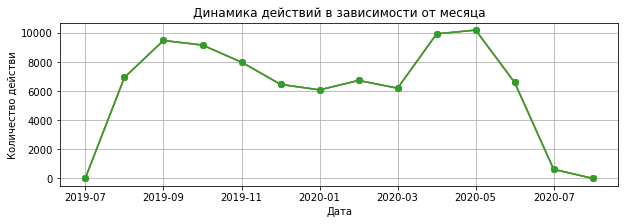

In [43]:
# построим распределение по рассылкам 
engagement.query('month_date != "NaT"').\
pivot_table(index = 'month_date', values = ['sent', 'delivered', 'opened'], aggfunc = ['sum']).\
plot(grid=True, style = 'o-', title = 'Динамика действий в зависимости от месяца', legend = False, figsize=(10, 3));
plt.xlabel('Дата')
plt.ylabel('Количество действи');

### Зависимость возможно сезонная и могла быть связанна с короновирусом

### Взглянем на действия тех пользователей которые открывают рассылки

In [44]:
# посчитаем кол-во действий 
engagement_cnt = engagement.groupby(['сonsumer_id', 'month_date']).\
agg(sent = ('sent','sum'), delivered = ('delivered','sum'), opened = ('opened','sum'), clicked = ('clicked','sum'), 
     unsubscribed = ('unsubscribed','sum')).reset_index()

In [45]:
# посчитаем кол-во действий без оттока
engagement_cnt_0 = engagement.query('unsubscribed == 0').groupby(['сonsumer_id', 'month_date']).\
agg(sent = ('sent','sum'), delivered = ('delivered','sum'), opened = ('opened','sum'), clicked = ('clicked','sum'), 
     unsubscribed = ('unsubscribed','sum')).reset_index()

In [46]:
# посчитаем кол-во действий с оттоком
engagement_cnt_1 = engagement.query('unsubscribed == 1').groupby(['сonsumer_id', 'month_date']).\
agg(sent = ('sent','count'), delivered = ('delivered','sum'), opened = ('opened','sum'), clicked = ('clicked','sum'), 
     unsubscribed = ('unsubscribed','sum')).reset_index()

**Посчитаем среднее кол-во действий в месяц**

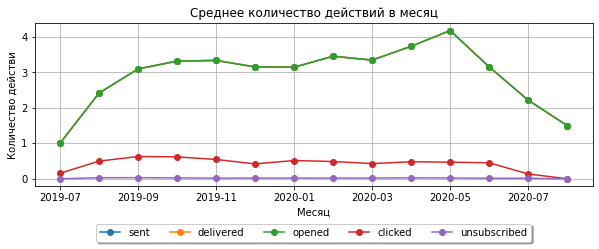

In [47]:
engagement_cnt.query('month_date != "NaT"').groupby(['month_date']).mean().\
plot(grid=True, style = 'o-', title = 'Среднее количество действий в месяц', figsize=(10, 3))
plt.xlabel('Месяц')
plt.ylabel('Количество действи');
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=5);

**Посчитаем среднее кол-во подписок без учёта отписок**

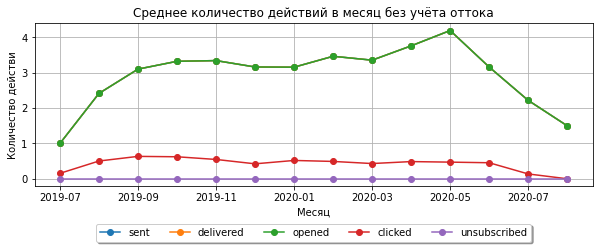

In [48]:
engagement_cnt_0.query('month_date != "NaT"').groupby(['month_date']).mean().\
plot(grid=True, style = 'o-', title = 'Среднее количество действий в месяц без учёта оттока', figsize=(10, 3))
plt.xlabel('Месяц')
plt.ylabel('Количество действи')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=5);

**Посчитаем среднее кол-во подписок с учётом отписок**

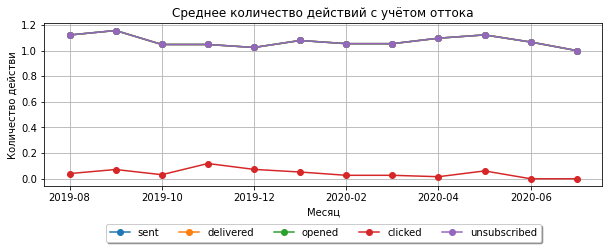

In [49]:
engagement_cnt_1.query('month_date != "NaT"').groupby(['month_date']).mean().plot(grid=True, style = 'o-', figsize=(10, 3))
plt.title('Среднее количество действий с учётом оттока')
plt.xlabel('Месяц')
plt.ylabel('Количество действи');
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), fancybox=True, shadow=True, ncol=5);

**Вывод:** 

- Количество рассылок едва влияет на отток. Среднее количество рассылок в высокий сезон, 3-4 рассылки, в низкий - 3 рассылки

### Посмотрим на отток в разрезе продаж

**Мы предполагаем, что все покупки происходят из-за рассылок. Сравним рассылки с транзакциями по количеству в действий в месяц + id клиента**

In [50]:
# дополним таблицу transactions датами месяца
transactions['month_date'] = transactions['order_date'].apply(lambda x: pd.Timestamp(x).strftime("%Y-%m") if pd.notnull(x) else 'NaT')

In [51]:
# посчитаем факт покупки на каждого клиента 
transactions_cnt = transactions.groupby(['сonsumer_id', 'month_date']).\
agg(transactions = ('nr_of_transactions','count'))

In [52]:
# составим общую таблицу
df = engagement.merge(transactions_cnt, on = ['сonsumer_id', 'month_date'], how = 'left').merge(members, on = ['сonsumer_id'], how = 'left')

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 919961 entries, 0 to 919960
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   сonsumer_id           919961 non-null  object        
 1   campaign_delivery_id  919961 non-null  int64         
 2   opened_date_hour      86453 non-null   datetime64[ns]
 3   sent                  919961 non-null  int64         
 4   delivered             919961 non-null  int64         
 5   opened                919961 non-null  int64         
 6   clicked               919961 non-null  int64         
 7   unsubscribed          919961 non-null  int64         
 8   month_date            919961 non-null  object        
 9   transactions          6310 non-null    float64       
 10  age                   672606 non-null  float64       
 11  gender                919961 non-null  int32         
 12  first_signup_date     919961 non-null  datetime64[ns]
dtyp

In [54]:
# заполним пропущенные значение
df['transactions'] = df['transactions'].fillna(0).astype('int64')
df['age'] = df['age'].fillna(0).astype('int64')
df['gender'] = df['gender'].fillna(0).astype('int64')

Назначим конверсии и посчитаем их:

`CCS` - конверсия в доставку 

`CDO` - конверсия в открытие

`COC` - конверсия в клики

`CUC` - конверсия в отписку

`CCT` - конверсия в покупку
    

In [55]:
df_cnt = df.groupby(['сonsumer_id', 'month_date']).\
agg(sent = ('sent','sum'), delivered = ('delivered','sum'), opened = ('opened','sum'), clicked = ('clicked','sum'),
    unsubscribed = ('unsubscribed','sum'), transactions = ('transactions','sum')).\
assign(CCS = lambda x: x['delivered']/x['sent'], CDO = lambda x: x['opened']/x['delivered'], 
       COC = lambda x: x['clicked']/x['opened'], CUC = lambda x: x['unsubscribed']/x['clicked'], 
       CCT = lambda x: x['clicked']/x['transactions']).reset_index()

df_cnt = df_cnt.fillna(0)

df_cnt.head()

,сonsumer_id,month_date,sent,delivered,opened,clicked,unsubscribed,transactions,CCS,CDO,COC,CUC,CCT
0,003GH1K9GPLAB0WG,NaT,51,51,0,0,0,0,1.000,0.000,0.000,0.000,0.000
1,0049U5ZF5M0KFYTZ,2019-08,2,2,2,0,0,0,1.000,1.000,0.000,0.000,0.000
2,0049U5ZF5M0KFYTZ,2019-10,24,24,24,0,0,0,1.000,1.000,0.000,0.000,0.000
3,0049U5ZF5M0KFYTZ,2019-12,1,1,1,0,0,0,1.000,1.000,0.000,0.000,0.000
4,0049U5ZF5M0KFYTZ,2020-03,1,1,1,0,0,0,1.000,1.000,0.000,0.000,0.000


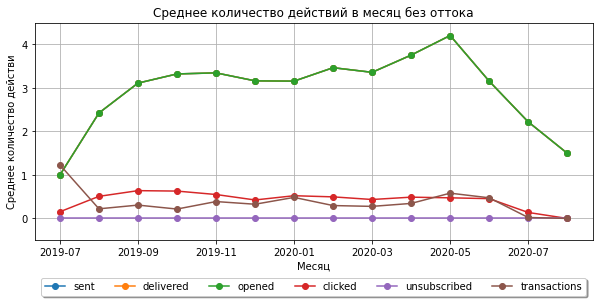

In [56]:
df_cnt.drop(columns = (['CCS','CDO','COC','CUC','CCT'])).\
query('month_date != "NaT" and unsubscribed == 0').groupby(['month_date']).mean().\
plot(grid=True, style = 'o-', title = 'Среднее количество действий в месяц без оттока', figsize=(10, 4))
axes = plt.axes()
axes.set_ylim([-0.5, 4.5])
plt.xlabel('Месяц')
plt.ylabel('Среднее количество действи');
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=6);

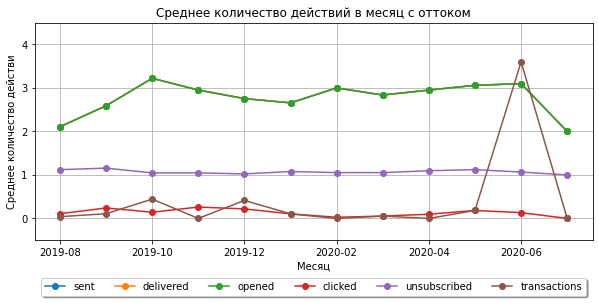

In [57]:
df_cnt.drop(columns = (['CCS','CDO','COC','CUC','CCT'])).\
query('month_date != "NaT" and unsubscribed != 0').groupby(['month_date']).mean().\
plot(grid=True, style = 'o-', title = 'Среднее количество действий в месяц с оттоком', figsize=(10, 4))
axes = plt.axes()
axes.set_ylim([-0.5, 4.5])
plt.xlabel('Месяц')
plt.ylabel('Среднее количество действи');
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=6);

**Вывод:** 

- Уровень транзакций стремится к единице без учёта оттока. Рассылки колеблются от 3х до 4х. 
- Уровень транзакций стремится к нулю с учётом оттока и уровень рассылок ближе к 3. Соответственно среднее количество рассылок и транзакций на отток не влияет.
- Пик покупок на 2020-06 месяце скорее аномалия, чем нормальное поведение клиентов. 

**Рассмотрим количество действий в разрезе гендерного различия**

In [58]:
df['gender'].value_counts(True)

1   0.469
0   0.385
3   0.135
2   0.011
Name: gender, dtype: float64

In [59]:
df['gender'].value_counts()

1    431700
0    354286
3    124001
2      9974
Name: gender, dtype: int64

In [60]:
gender_df = df.groupby(['gender']).agg(sent = ('sent','sum'), delivered = ('delivered','sum'), opened = ('opened','sum'), clicked = ('clicked','sum'),
    unsubscribed = ('unsubscribed','sum'), transactions = ('transactions','sum'), gender = ('gender','count')).\
assign(sent_percent = lambda x: x['sent']/x['sent'].sum(), delivered_percent = lambda x: x['delivered']/x['delivered'].sum(), 
       opened_percent = lambda x: x['opened']/x['opened'].sum(), clicked_percent = lambda x: x['clicked']/x['clicked'].sum(), 
       unsubscribed_percent = lambda x: x['unsubscribed']/x['unsubscribed'].sum(), transactions_percent = lambda x: x['transactions']/x['transactions'].sum(), 
       gender_percent = lambda x: x['gender'] /x['gender'].sum())

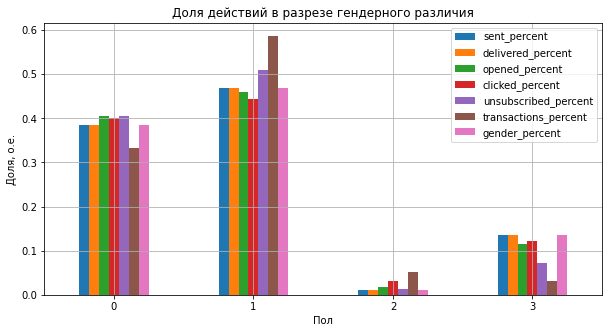

In [61]:
gender_df.drop(columns = (['sent','delivered','opened','clicked','unsubscribed','transactions','gender'])).\
plot(kind = 'bar', grid=True, style = 'o-', title = 'Доля действий в разрезе гендерного различия', figsize=(10, 5));
plt.xticks(rotation='horizontal')
plt.xlabel('Пол')
plt.ylabel('Доля, о.е.');

`Female` - 0, 
`Male` - 1, 
`Prefer Not to Say` - 2, 
`Not Set` -  3

**Вывод:** 
- Мужской пол более склонен к покупкам по сравнению с женским, примерно на 10-20% больше, если уравнивать % соотношение полов 50/50. 
- Пол номер `2` покупают в 2 раза больше чем кликают.

### Проверка гипотез Заказчика.

**Гипотеза 1** - О “пассивной отписке”: когда человеку показалось, что ему пишут слишком много, и он просто перестает открывать рассылки, хоть и не готов отписываться

**Посчитаем среднее количество открытий**

In [62]:
df_cnt['opened'].mean()

2.1495027349577325

**Среднее количество открытий - 2. Возьмём это число за нормальное (не большое) количество рассылок.**

**Проверим статистическую разницу долей (конверсий) z-критерием.**

Итак, предположим:

- Если пользователю посылают две рассылки и далее более двух он **не** открывает, значит рассылки больше не интересуют пользователя
- Если пользователю посылают две рассылки и далее более двух он открывает, значит рассылки всё ещё интересуют пользователя

**Поделим пользователей на доли с двумя открытиями и более двух открытий рассылок**

*Сформулируем гипотезы H0 и H1 для анализа долей:*

> Нулевая гипотеза H0 - "Нет оснований считать доли разными"

> Альтернативная гипотеза Н1 - "Между долями есть значимая разница"

**Сформируем датафрейм для проверки гипотезы по сумме всех действий каждого пользователя относящихся к открытиям рассылок**

In [63]:
hypothesis_1 = engagement.groupby(['сonsumer_id']).\
agg(sent = ('sent','sum'), deliv = ('delivered','sum'), opened = ('opened','sum'), click = ('clicked','sum'), 
     unsub = ('unsubscribed','sum')).sort_values(by = 'unsub', ascending = False).reset_index()

In [64]:
from scipy import stats as st
import math as mth

alpha = .05 # критический уровень статистической значимости

successes = np.array([hypothesis_1.query('0 < opened <= 2')['сonsumer_id'].nunique(), hypothesis_1.query('opened > 2')['сonsumer_id'].nunique()])
trials = np.array([hypothesis_1.query('opened != 0')['сonsumer_id'].nunique(), hypothesis_1.query('opened != 0')['сonsumer_id'].nunique()])

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1) 

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

print("Разница пропорций в датасетах: {0:.3f}".format(difference))   

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница
Разница пропорций в датасетах: -0.377


### Гипотеза 1, о "пассивной отписке" когда человеку показалось, что ему пишут слишком много пишут не опровергнута 

**Гипотеза 2** - Клиент совершает покупку и через какое-то время теряет интерес к новостным рассылкам, во всяком случае рассылки на пользователя не генерят продажи

**Проверим статистическую разницу долей (конверсий) z-критерием.**

Итак, предположим:

- Если пользователь совершил всего одну покупку после рассылки, значит рассылки больше не генерят продажи и пользователь потерял интерес к рассылкам
- Если пользователь совершил более одной покупки после рассылки, значит рассылки всё ещё генерят продажи и пользователю интересны рассылки

**Поделим пользователей на доли с одной покупкой и более одной, среди пользователей, которые хоть раз что-то покупали**

*Сформулируем гипотезы H0 и H1 для анализа долей:*

> Нулевая гипотеза H0 - "Нет оснований считать доли разными"

> Альтернативная гипотеза Н1 - "Между долями есть значимая разница"

In [65]:
hypothesis_2 = df.groupby(['сonsumer_id']).\
agg(sent = ('sent','sum'), delivered = ('delivered','sum'), opened = ('opened','sum'), clicked = ('clicked','sum'),
    unsubscribed = ('unsubscribed','sum'), transactions = ('transactions','sum')).reset_index()

In [66]:
# зададим фильтр на более чем одно открытие рассылки
hypothesis_2['A'] = hypothesis_2['opened'] >= 1

In [67]:
alpha = .05 # критический уровень статистической значимости

successes = np.array([hypothesis_2[hypothesis_2['A']].query('transactions == 1')['сonsumer_id'].nunique(),
                      hypothesis_2[hypothesis_2['A']].query('transactions > 1')['сonsumer_id'].nunique()])

trials = np.array([hypothesis_2[hypothesis_2['A']].query('transactions != 0')['сonsumer_id'].nunique(), 
                   hypothesis_2[hypothesis_2['A']].query('transactions != 0')['сonsumer_id'].nunique()])

# пропорция успехов в первой группе:
p1 = successes[0]/trials[0]

# пропорция успехов во второй группе:
p2 = successes[1]/trials[1]

# пропорция успехов в комбинированном датасете:
p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

# разница пропорций в датасетах
difference = p1 - p2

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1) 

p_value = (1 - distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if (p_value < alpha):
    print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
else:
    print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

print("Разница пропорций в датасетах: {0:.3f}".format(difference))   

p-значение:  0.0
Отвергаем нулевую гипотезу: между долями есть значимая разница
Разница пропорций в датасетах: -0.535


### Гипотеза 2, о потери интереса после одной покупки при постоянных рассылках не опровергнута 

### Гипотеза о потери интереса после одной покупки при постоянных рассылках не опровергнута 

### Кластеризация клиентов. Сделаем срез с учётом бизнес правил. Возьмем открытия за последние на 6 месяцев (180 дней)

In [68]:
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler

In [69]:
df_k = df.query('opened_date_hour > "2020-02-01 00:00:00"').\
groupby(['сonsumer_id', 'gender', 'age']).\
agg(campaign_cnt = ('campaign_delivery_id', 'count'), sent = ('sent','sum'), 
delivered = ('delivered','sum'), opened = ('opened','sum'), clicked = ('clicked','sum'),
unsubscribed = ('unsubscribed','sum'), transactions = ('transactions','sum')).reset_index()

df_k.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4759 entries, 0 to 4758
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   сonsumer_id   4759 non-null   object
 1   gender        4759 non-null   int64 
 2   age           4759 non-null   int64 
 3   campaign_cnt  4759 non-null   int64 
 4   sent          4759 non-null   int64 
 5   delivered     4759 non-null   int64 
 6   opened        4759 non-null   int64 
 7   clicked       4759 non-null   int64 
 8   unsubscribed  4759 non-null   int64 
 9   transactions  4759 non-null   int64 
dtypes: int64(9), object(1)
memory usage: 371.9+ KB


In [70]:
# стандартизируем данные
sc = StandardScaler() # создаём объект класса scaler (нормализатор)
# обучаем нормализатор и преобразуем набор данных без учёта оттока, чтобы это не повлияло на модель
X_sc = sc.fit_transform(df_k.drop(columns = (['сonsumer_id','unsubscribed']))) 

In [71]:
# построим матрицу расстояний
linked = linkage(X_sc, method = 'ward')

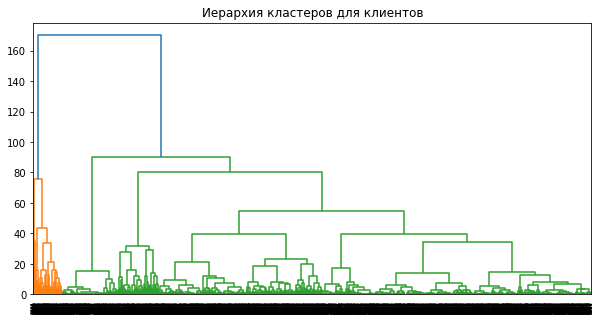

In [72]:
# визуализируем таблицу расстояний linked
plt.figure(figsize=(10, 5))  
dendrogram(linked, orientation='top')
plt.title('Иерархия кластеров для клиентов')
plt.show()

In [73]:
# задаём модель k_means с числом кластеров 2
km = KMeans(n_clusters = 2, random_state = 0) 
# прогнозируем кластеры для наблюдений
labels = km.fit_predict(X_sc)

# сохраняем метки кластера в поле нашего датасета
df_k['cluster_km'] = labels

In [74]:
# выводим статистику по средним значениям наших признаков по кластеру
df_k.groupby(['cluster_km']).mean().sort_values('unsubscribed') 

,gender,age,campaign_cnt,sent,delivered,opened,clicked,unsubscribed,transactions
cluster_km,,,,,,,,,
0,0.838,28.067,51.407,51.407,51.407,51.407,5.448,0.031,7.694
1,0.829,24.104,4.961,4.961,4.961,4.961,0.723,0.051,0.385


In [78]:
df_k['cluster_km'].value_counts()

1    4400
0     359
Name: cluster_km, dtype: int64

In [82]:
df_k.head()

,сonsumer_id,gender,age,campaign_cnt,sent,delivered,opened,clicked,unsubscribed,transactions,cluster_km,mean_cnt,recommended_cnt,more_less
0,0049U5ZF5M0KFYTZ,1,39,2,2,2,2,1,0,0,1,3,0,Нет
1,006ZYWZO9M7FS9BT,1,33,9,9,9,9,0,0,0,1,3,0,Нет
2,00DCPBGJM1QIQXIW,2,0,11,11,11,11,3,0,0,1,3,0,Нет
3,00TI571R5PPZPVKN,3,0,4,4,4,4,0,0,0,1,3,0,Нет
4,00TTINX4Y1K2JHB1,1,16,3,3,3,3,0,0,0,1,3,0,Нет


In [76]:
# вычислим среднее в месяц
df_k.groupby(['cluster_km']).mean().sort_values('unsubscribed') / 6 

,gender,age,campaign_cnt,sent,delivered,opened,clicked,unsubscribed,transactions
cluster_km,,,,,,,,,
0,0.140,4.678,8.568,8.568,8.568,8.568,0.908,0.005,1.282
1,0.138,4.017,0.827,0.827,0.827,0.827,0.121,0.009,0.064


In [88]:
# добавим в датасет столбцы с средним и рекомендуемымы количеством рассылок 
def mean_cnt(row):
    if row['cluster_km'] == 1 or row['cluster_km'] == 0:     
        return 3

def recommended_cnt(row):
    if row['cluster_km'] == 1:
        return 1
    else:
        return 8

def recommended_age(row):
    if row['cluster_km'] == 1:
        return 24
    else:
        return 28    
       
# пришьём цикл к данным 
df_k['mean_cnt'] = df_k.apply(mean_cnt, axis = 1)
df_k['recommended_cnt'] = df_k.apply(recommended_cnt, axis = 1)
df_k['recommended_age'] = df_k.apply(recommended_age, axis = 1)

def more_less(row):
    if row['recommended_cnt'] > row['mean_cnt']:
        return 'Да'
    else:
        return 'Нет'

df_k['more_less'] = df_k.apply(more_less, axis = 1)

# и проверим
print(df_k['cluster_km'].value_counts())
print(df_k['mean_cnt'].value_counts())
print(df_k['recommended_cnt'].value_counts())
print(df_k['recommended_age'].value_counts())
print(df_k['more_less'].value_counts())

1    4400
0     359
Name: cluster_km, dtype: int64
3    4759
Name: mean_cnt, dtype: int64
1    4400
8     359
Name: recommended_cnt, dtype: int64
24    4400
28     359
Name: recommended_age, dtype: int64
Нет    4400
Да      359
Name: more_less, dtype: int64


In [89]:
df_k.to_excel("C:/Users/PC/проекты Яндекс/Сайд проекты/Adidas/customer_table.xlsx")

**Построим распределения признаков для кластеров**

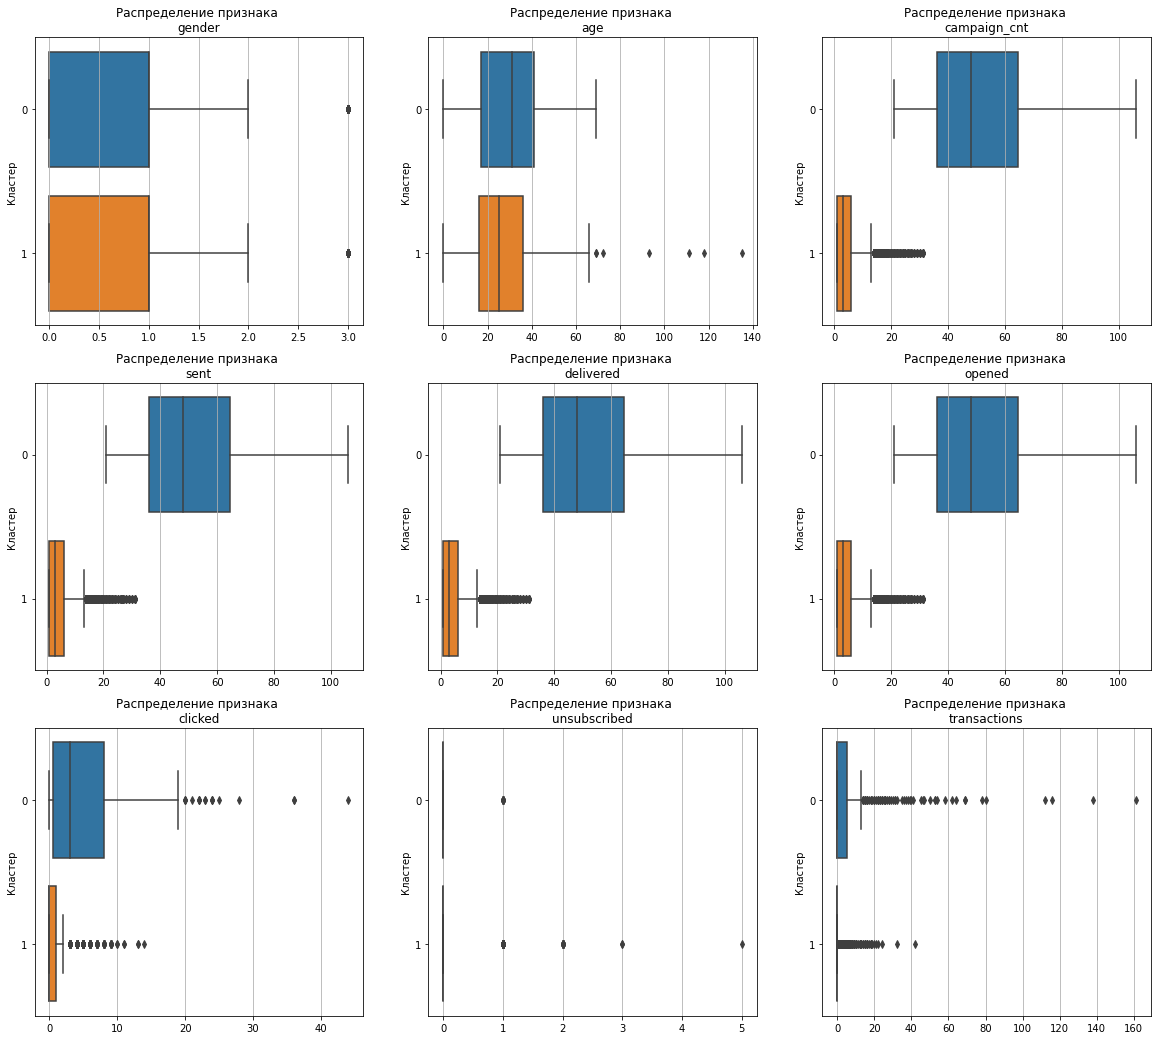

In [77]:
cols_var = ['gender', 'age', 'campaign_cnt', 'sent', 'delivered', 'opened', 'clicked', 'unsubscribed', 'transactions']
for i, col in enumerate(cols_var):
    plt.subplot(3, 3, i+1)
    fig = plt.gcf()
    fig.set_size_inches(20, 18)
    sns.boxplot(data = df_k, x = col, y = 'cluster_km', orient = 'h')
    plt.title('Распределение признака \n'+ str(col))
    plt.ylabel('Кластер')
    plt.xlabel('')
    plt.grid(axis = 'x')
    plt.title('Распределение признака \n'+ str(col))

**Вывод:** 

Средние значения пользовательских кластеров активных пользователей за 6 месяцев (180 дней)

`Кластер 0`
- пол не имеет значения;
- возраст 28 лет;
- число компаний в месяц 8-9;
- число кликов в месяц 9;
- число покупок в месяц 1-2;
- склонность к оттоку в 2 раза меньше, чем у кластера 1.

`Кластер 1`
- пол не имеет значения;
- возраст 24 года;
- число компаний в месяц 1;
- число кликов в месяц 0-1;
- число покупок в месяц 0;
- склонность к оттоку в 2 раза больше, чем у кластера 0.

### Шаг. 4. Презентация и оформление проекта

**Общие выводы:**

- Отписавшихся менее 0,1%. Этот показатель вряд ли будет как-то влиять на количество рассылок;
- 98% клиентов не открывали сообщения, которые им приходили;
- Среднее количество рассылок в высокий сезон, 3-4 рассылки, в низкий - 3 рассылки;
- Уровень транзакций стремится к единице без учёта оттока. Рассылки колеблются от 3х до 4х;
- Уровень транзакций стремится к нулю с учётом оттока и уровень рассылок ближе к 3. Соответственно среднее количество рассылок и транзакций на отток не влияет;
- Пик покупок на 2020-06 месяце скорее аномалия, чем нормальное поведение клиентов;
- Мужской пол более склонен к покупкам, примерно на 10-20% больше, если уравнивать % соотношение полов 50/50; 
- Пол номер `2` покупают в 2 раза больше, чем кликают;

Проверка гипотез:
- Гипотеза 1, о "пассивной отписке" когда человеку показалось, что ему пишут слишком много пишут не опровергнута; 
- Гипотеза 2, о потери интереса после одной покупки при постоянных рассылках не опровергнута; 

Средние значения параметров кластеров активных пользователей за 6 месяцев (180 дней): 

`Кластер 0`
- пол не имеет значения;
- возраст 28 лет;
- число компаний в месяц 8-9;
- число кликов в месяц 9;
- число покупок в месяц 1-2;
- склонность к оттоку в 2 раза меньше, чем у кластера 1.

`Кластер 1`
- пол не имеет значения;
- возраст 24 года;
- число компаний в месяц 1;
- число кликов в месяц 0-1;
- число покупок в месяц 0;
- склонность к оттоку в 2 раза больше, чем у кластера 0.
